In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch.optim as optim
from torchvision import datasets, transforms
from vae_ludo.impl_vae import ConvVAE
from vae_ludo.losses import VAELoss
from common import training

In [18]:
# This project requires Python 3.10 or above:
import sys
assert sys.version_info >= (3, 10)

# We also need PyTorch ≥ 2.6.0:
from packaging.version import Version
import torch
assert Version(torch.__version__) >= Version("2.6.0")

import os
from torch.utils.data import DataLoader
import torch.nn as nn
import torchmetrics
import matplotlib.pyplot as plt

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Hyperparameters
latent_dim = 10
batch_size = 64
epochs = 1
lr = 1e-3
# log_interval = 100

In [21]:
# model_dir = "checkpoints"
# os.makedirs(model_dir, exist_ok=True)

In [22]:
from common import data
# Load dataset, split it, and load it into DataLoaders
dataset_dir = "/home/ludo/Dev/personale/datasets/"
train_data, valid_data, test_data = data.loadDataset("mnist", dataset_dir)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [23]:
model_vae = ConvVAE(28*28, 3, 0.3)

In [24]:
import torchinfo
torchinfo.summary(model_vae)

Layer (type:depth-idx)                   Param #
ConvVAE                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       136
│    └─BatchNorm2d: 2-2                  16
│    └─LeakyReLU: 2-3                    --
│    └─Dropout2d: 2-4                    --
│    └─Conv2d: 2-5                       2,064
│    └─BatchNorm2d: 2-6                  32
│    └─LeakyReLU: 2-7                    --
│    └─Dropout2d: 2-8                    --
│    └─Flatten: 2-9                      --
│    └─Linear: 2-10                      50,240
│    └─BatchNorm1d: 2-11                 128
│    └─LeakyReLU: 2-12                   --
│    └─Dropout: 2-13                     --
│    └─Linear: 2-14                      390
├─Sequential: 1-2                        --
│    └─Linear: 2-15                      256
│    └─BatchNorm1d: 2-16                 128
│    └─LeakyReLU: 2-17                   --
│    └─Dropout: 2-18                     --
│    └─Linear: 

In [25]:

# let's train the model
torch.manual_seed(42)
loss = VAELoss(0.001)
optimizer = torch.optim.NAdam(model_vae.parameters(), lr=3e-3)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = training.train(model_vae, optimizer, loss, rmse, train_loader,
                valid_loader, device=device, n_epochs=2, reconstruct=True)


Epoch 1/2,                      train loss: 0.0920, train metric: 0.3, valid metric: 0.246
Epoch 2/2,                      train loss: 0.0659, train metric: 0.25, valid metric: 0.226


In [26]:
curr_X_test, curr_Y_test = next(iter(valid_loader))
out = model_vae(curr_X_test)

<Figure size 800x400 with 0 Axes>

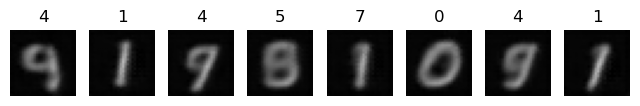

In [27]:
import common.plots as pl
pl.plot_images_mnist(out.x_recon, curr_Y_test)